In [ ]:
import re
from datetime import datetime
from pathlib import Path
import pandas as pd
import nest_asyncio
import asyncpraw
import asyncio
import os

nest_asyncio.apply()

def clean_text(text):

    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

async def scrape_reddit():
    #purposefully inculded keys as account is no longer active
    reddit = asyncpraw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent="my_app"
)

    submission = await reddit.submission(url='https://www.reddit.com/r/SouthwestAirlines/comments/1j8nu86/southwest_will_now_charge_you_for_checking_bags/')
    await submission.comments.replace_more(limit=0)

    sw_comments = []
    sw_comment_date = []

    for comment in submission.comments.list():
      if comment.body.lower() in ['[deleted]', '[removed]']:
            continue
      cleaned_comment = clean_text(comment.body)
      sw_comments.append(cleaned_comment)
      readable_date = datetime.utcfromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M')
      sw_comment_date.append(readable_date)

    df = pd.DataFrame({'Date': sw_comment_date, 'Comment': sw_comments})
    df.drop_duplicates(subset='Comment', inplace=True)

    await reddit.close()

    return df

df = await scrape_reddit()

df.to_csv(Path("data/southwest_reddit_comments_noreplies.csv"), index=False, encoding="utf-8")


RequestException: error with request Cannot connect to host www.reddit.com:443 ssl:True [SSLCertVerificationError: (1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1018)')]

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

raw_data = pd.read_csv(Path("data/southwest_reddit_comments_noreplies.csv"), encoding="utf-8")

sia = SentimentIntensityAnalyzer()

sentiment_scores = []
for comment in raw_data['Comment']:
    compound = sia.polarity_scores(comment)['compound']
    sentiment_scores.append(compound)

raw_data['Sentiment'] = sentiment_scores

raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')

daily_sentiment = raw_data.groupby(raw_data['Date'].dt.floor('h'))['Sentiment'].mean()

plt.figure(figsize=(14, 6))
plt.scatter(daily_sentiment.index, daily_sentiment.values, color='blue', s=50)
plt.plot(daily_sentiment.index, daily_sentiment.values, linestyle='-')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y %H:%M'))
plt.xticks(rotation=45)
plt.title("Average Reddit Comment Sentiment Per Hour (VADER)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.axhline(0, color='black', linestyle='--', label='Neutral baseline (0)')
plt.ylabel("Average Sentiment Score (-1: Negative, 1: Positive)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/southwest_reddit_comments_noreplies.csv'

In [11]:
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="hf-inference",
    api_key=os.getenv("HF_API_KEY")
)
bert_df = pd.read_csv(Path("data/southwest_reddit_comments_noreplies.csv"), encoding='utf-8')

results = []
for i, comment in enumerate(bert_df['Comment']):

    if len(comment) > 512:
        comment = comment[:512]

    result = client.text_classification(
      text=comment,
      model= "distilbert/distilbert-base-uncased-finetuned-sst-2-english",
        )

    results.append(result[0])



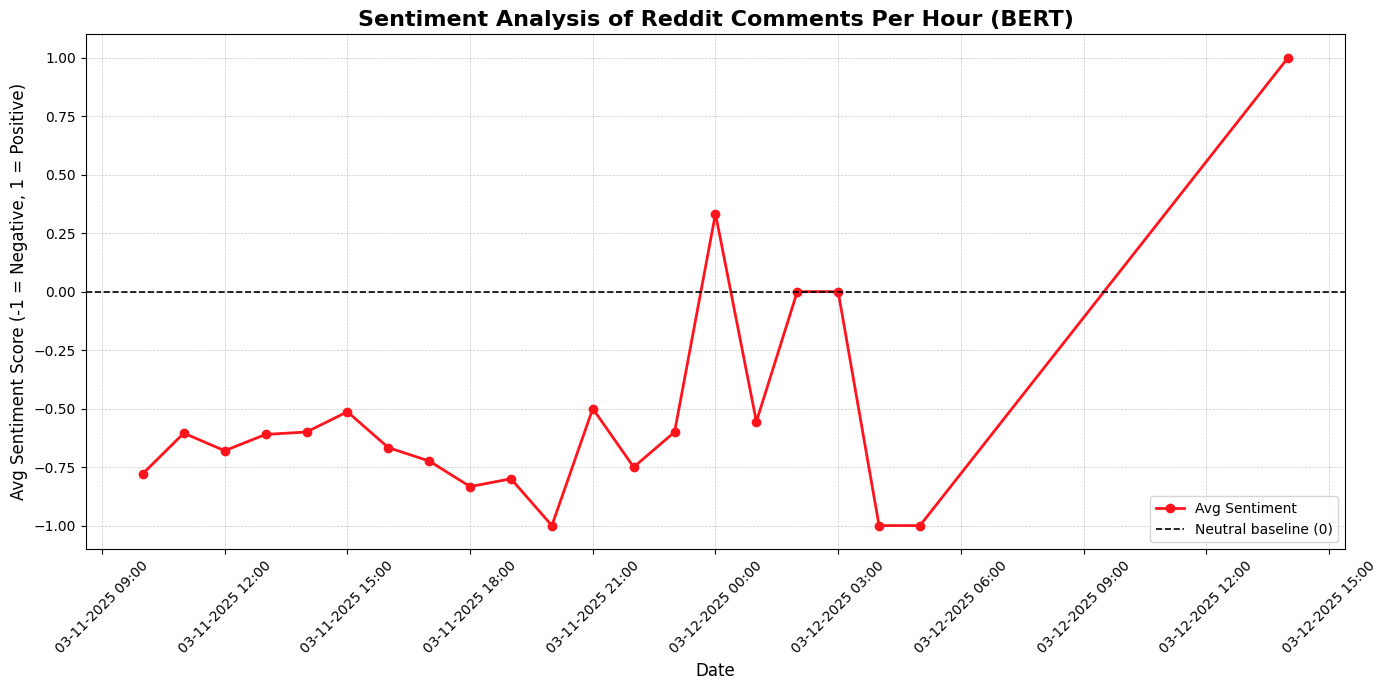

In [12]:

labels = [r['label'] for r in results]

bert_df['SentimentLabel'] = labels

bert_df['SentimentScore'] = bert_df['SentimentLabel'].map({'POSITIVE': 1, 'NEGATIVE': -1})

# Ensure datetime format
bert_df['Date'] = pd.to_datetime(bert_df['Date'], errors='coerce')

# Group by hour
hourly_sentiment = bert_df.groupby(bert_df['Date'].dt.floor('h'))['SentimentScore'].mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(hourly_sentiment.index, hourly_sentiment.values,
         marker='o', linestyle='-', color='#ff141d', linewidth=2, markersize=6, label='Avg Sentiment')

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y %H:%M'))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Horizontal neutral line
plt.axhline(0, color='black', linestyle='--', linewidth=1.2, label='Neutral baseline (0)')

# Styling
plt.title("Sentiment Analysis of Reddit Comments Per Hour (BERT)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Avg Sentiment Score (-1 = Negative, 1 = Positive)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()